In [1]:
import sys, numpy as np
from keras.datasets import mnist
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

(x_train, y_train), (x_test, y_test) = mnist.load_data()

#normalizing the input by dividing it by 255
images, labels = (x_train[0:1000].reshape(1000,28*28) / 255, y_train[0:1000])

#encode labels into one hot vector
one_hot_labels = np.zeros((len(labels),10))
for i,l in enumerate(labels):
    one_hot_labels[i][l] = 1
labels = one_hot_labels

#normalizing and reshaping for test images
test_images = x_test.reshape(len(x_test),28*28) / 255
test_labels = np.zeros((len(y_test),10))
for i,l in enumerate(y_test):
    test_labels[i][l] = 1
    

11493376/11490434 [==============================] - 0s 0us/step


In [8]:
np.random.seed(1)

def relu(x):
    return (x >= 0) * x 

def relu2deriv(output):
    return output >= 0 

batch_size = 20
alpha, iterations = (0.004, 200)
pixels_per_image, num_labels, hidden_size,hidden_size1 = (784, 10, 100,50)

#weights initialization
weights_0_1 = 0.2*np.random.random((pixels_per_image,hidden_size)) - 0.1
weights_1_2 = 0.2*np.random.random((hidden_size,hidden_size1)) - 0.1
weights_2_3 = 0.2*np.random.random((hidden_size1,num_labels)) - 0.1

In [9]:
# reshaping input into 4 dimensions for data augmentation
images = images.reshape(-1,28,28,1)
images.shape

(1000, 28, 28, 1)

In [10]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

#fitting imaage generator on input
datagen.fit(images)

In [11]:
for j in range(iterations):
  error, correct_cnt = (0.0, 0)
  i=0
  #iterator of data augmentaion in batches
  for x_batch,y_batch in datagen.flow(images,labels,batch_size):
    if i >= 10:
      break
    x_batch.shape=(batch_size,784)
    layer_0 = x_batch
    layer_1 = relu(np.dot(layer_0,weights_0_1))

    # drop few neurons from layer 1 to avoid overfitting
    dropout_mask = np.random.randint(2,size=layer_1.shape)
    layer_1 *= dropout_mask * 4
    layer_2 = (np.dot(layer_1,weights_1_2))
    layer_3 = np.dot(layer_2,weights_2_3)

    error += np.sum((y_batch - layer_3) ** 2)

    for k in range(batch_size):
      correct_cnt += int(np.argmax(layer_3[k:k+1]) == np.argmax(y_batch[k:k+1]))

      # 3 layer neural network
      layer_3_delta=(y_batch-layer_3)/batch_size
      layer_2_delta=layer_3_delta.dot(weights_2_3.T)
      layer_1_delta=layer_2_delta.dot(weights_1_2.T)*relu2deriv(layer_1)
      layer_1_delta *= dropout_mask

      weights_2_3+=alpha*layer_2.T.dot(layer_3_delta)
      weights_1_2+=alpha*layer_1.T.dot(layer_2_delta)
      weights_0_1+=alpha*layer_0.T.dot(layer_1_delta)
    
    i+=1
  
  if(j%10 == 0):
    test_error = 0.0
    test_correct_cnt = 0

    y_pred=[]
    y_true=[]
    for i in range(len(test_images)):
      layer_0 = test_images[i:i+1]
      layer_1 = relu(np.dot(layer_0,weights_0_1))
      layer_2 = (np.dot(layer_1, weights_1_2))
      layer_3 = np.dot(layer_2,weights_2_3)

      y_pred.append((np.argmax(layer_3)))
      y_true.append(int(np.argmax(test_labels[i:i+1])))
 
      test_error += np.sum((test_labels[i:i+1] - layer_3) ** 2)
      test_correct_cnt += int(np.argmax(layer_3) == np.argmax(test_labels[i:i+1]))
    sys.stdout.write("\n" + \
      "I:" + str(j) + \
       " Test-Err:" + str(test_error/ float(len(test_images)))[0:5] +\
       " Test-Acc:" + str(test_correct_cnt/ float(len(test_images))))
    
     # " Train-Err:" + str(error/ float(1000))[0:5] +\
     # " Train-Acc:" + str(correct_cnt/ float(len(images))))      


I:0 Test-Err:0.888 Test-Acc:0.2579
I:10 Test-Err:0.819 Test-Acc:0.479
I:20 Test-Err:0.799 Test-Acc:0.5172
I:30 Test-Err:0.772 Test-Acc:0.6294
I:40 Test-Err:0.748 Test-Acc:0.6196
I:50 Test-Err:0.737 Test-Acc:0.6185
I:60 Test-Err:0.741 Test-Acc:0.6407
I:70 Test-Err:0.726 Test-Acc:0.6686
I:80 Test-Err:0.715 Test-Acc:0.6897
I:90 Test-Err:0.702 Test-Acc:0.6683
I:100 Test-Err:0.707 Test-Acc:0.6692
I:110 Test-Err:0.708 Test-Acc:0.6634
I:120 Test-Err:0.698 Test-Acc:0.684
I:130 Test-Err:0.708 Test-Acc:0.6831
I:140 Test-Err:0.700 Test-Acc:0.666
I:150 Test-Err:0.690 Test-Acc:0.6368
I:160 Test-Err:0.701 Test-Acc:0.6624
I:170 Test-Err:0.697 Test-Acc:0.6844
I:180 Test-Err:0.695 Test-Acc:0.7212
I:190 Test-Err:0.678 Test-Acc:0.6759

In [ ]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

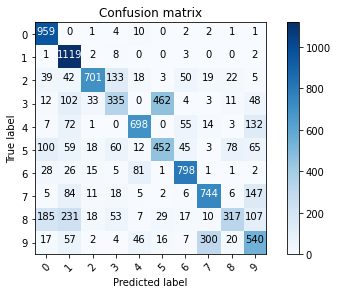

In [ ]:
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, classes = range(10)) 